# VAR Model

--- Loading User-Provided Time Series Data (N=12) ---
--- Plotting Time Series Observations with Decade Intervals ---


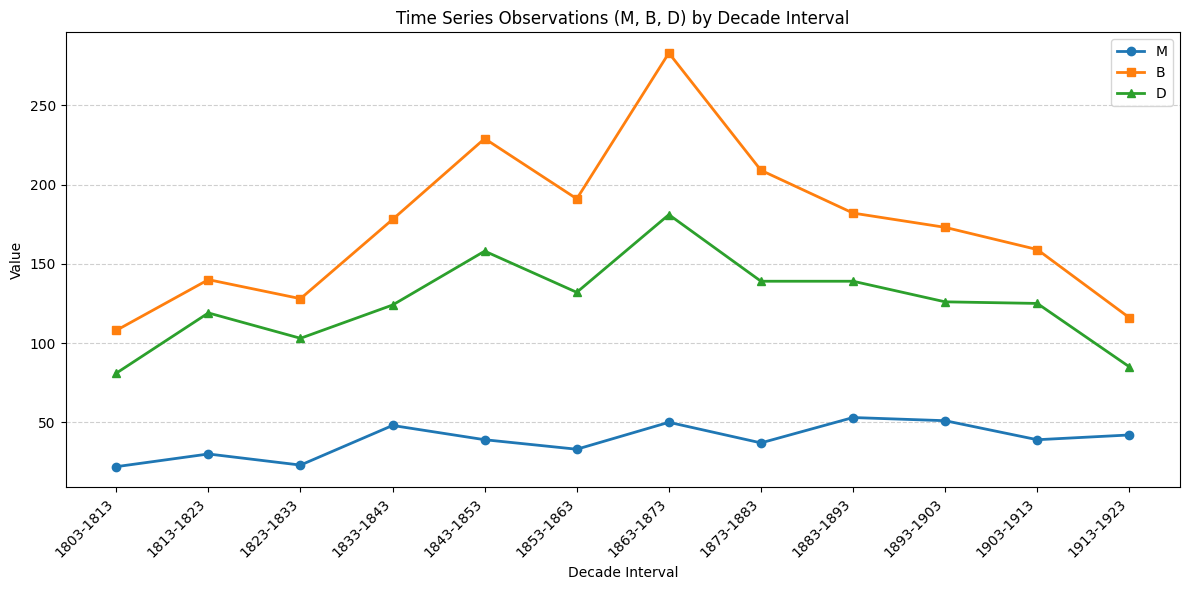

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load User Data ---

print("--- Loading User-Provided Time Series Data (N=12) ---")

M_obs = [22, 30, 23, 48, 39, 33, 50, 37, 53, 51, 39, 42]
B_obs = [108, 140, 128, 178, 229, 191, 283, 209, 182, 173, 159, 116]
D_obs = [81, 119, 103, 124, 158, 132, 181, 139, 139, 126, 125, 85]
N = len(M_obs)

# We use the starting year for plotting position but define new labels.
date_positions = [1803, 1813, 1823, 1833, 1843, 1853, 1863, 1873, 1883, 1893, 1903, 1913]

# --- MODIFICATION: Create the custom interval labels for the x-axis ---
date_labels = []
for start_year in date_positions:
    end_year = start_year + 10
    label = f"{start_year}-{end_year}"
    date_labels.append(label)
# The last label will be "1913-1923"

# Combine into a Pandas DataFrame
data = pd.DataFrame({'M': M_obs, 'B': B_obs, 'D': D_obs})

# --- 1.5. Plot the Data (Modified with Decade Intervals) ---

print("--- Plotting Time Series Observations with Decade Intervals ---")

plt.figure(figsize=(12, 6))

# Use the date_positions list for the actual x-coordinates
plt.plot(date_positions, data['M'], label='M', marker='o', linewidth=2)
plt.plot(date_positions, data['B'], label='B', marker='s', linewidth=2)
plt.plot(date_positions, data['D'], label='D', marker='^', linewidth=2)

plt.title('Time Series Observations (M, B, D) by Decade Interval')
plt.xlabel('Decade Interval')
plt.ylabel('Value')

# Set x-ticks to be the year positions and apply the custom interval labels
plt.xticks(date_positions, date_labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [21]:
from statsmodels.tsa.api import VAR

# --- 2. VAR Model Estimation ---

# Instantiate the VAR model
model = VAR(data)

# Fix the lag to 1.
optimal_lag = 1
print(f"\nFor demonstration, fixing the VAR lag to {optimal_lag}. Sample size N={N}.\n")

# Fit the VAR model using the fixed lag
results = model.fit(optimal_lag)

# --- 3. Display Results ---

print("--- VAR Model Estimation Results (Lag 1) ---")
# The summary shows the coefficients for each variable in each equation.
print(results.summary())


For demonstration, fixing the VAR lag to 1. Sample size N=12.

--- VAR Model Estimation Results (Lag 1) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Nov, 2025
Time:                     10:12:26
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    16.9144
Nobs:                     11.0000    HQIC:                   16.2067
Log likelihood:          -125.467    FPE:                1.59492e+07
AIC:                      16.4803    Det(Omega_mle):     6.28988e+06
--------------------------------------------------------------------
Results for equation M
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        40.900703        23.530461            1.738           0.082
L1.M          0.193064         0.425976            0.453    

In [11]:
from statsmodels.tsa.stattools import adfuller

# --- 2. Stationarity Test (Augmented Dickey-Fuller - ADF Test) ---

print("\n--- 2. Stationarity Test (ADF) ---")
print("Null Hypothesis (H0): The time series is NON-STATIONARY (it has a unit root).")
print("We reject H0 if p-value < 0.05.\n")

for name, series in data.items():
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    test_statistic = result[0]
    
    # We use a threshold of 0.05 for decision
    decision = "NON-STATIONARY (Accept H0)" if p_value > 0.05 else "**STATIONARY (Reject H0)**"

    print(f"Variable: {name}")
    print(f"  ADF Statistic: {test_statistic:.3f}")
    print(f"  p-value: {p_value:.3f}")
    print(f"  Conclusion: {decision}\n")
    
# NOTE: If any series is non-stationary, it should be differenced before VAR estimation (or a VECM should be used).


--- 2. Stationarity Test (ADF) ---
Null Hypothesis (H0): The time series is NON-STATIONARY (it has a unit root).
We reject H0 if p-value < 0.05.

Variable: M
  ADF Statistic: -1.161
  p-value: 0.690
  Conclusion: NON-STATIONARY (Accept H0)

Variable: B
  ADF Statistic: -1.646
  p-value: 0.459
  Conclusion: NON-STATIONARY (Accept H0)

Variable: D
  ADF Statistic: -2.004
  p-value: 0.285
  Conclusion: NON-STATIONARY (Accept H0)



In [18]:
from statsmodels.regression.linear_model import OLS

from statsmodels.regression.linear_model import OLS
# ADD THIS IMPORT:
import statsmodels.api as sm

# --- 3. Stability in Variance Test (ARCH-LM Test for Heteroscedasticity) ---

print("\n--- 3. Stability in Variance Test (ARCH-LM) ---")
print("Null Hypothesis (H0): Residuals are HOMOSCEDASTIC (stable variance).")
print("We reject H0 if p-value < 0.05.\n")

# Perform OLS on each variable against an intercept to get residuals
for name in data.columns:
    # Estimate a simple model: Y_t = c + epsilon_t
    # Since we have no predictors, we use OLS with only an intercept (add_constant)
    #odel_ols = OLS(data[name], pd.tools.add_constant(data[name].index)).fit()
    model_ols = OLS(data[name], sm.add_constant(data[name].index)).fit()
    
    # Use the ARCH-LM test on the residuals (default lag=1)
    arch_test = het_arch(model_ols.resid, maxlag=1)
    
    # arch_test returns: (LM-statistic, p-value, F-statistic, F-p-value)
    p_value_lm = arch_test[1]
    
    decision = "HOMOSCEDASTIC (Accept H0)" if p_value_lm > 0.05 else "**HETEROSCEDASTIC (Reject H0)**"

    print(f"Variable: {name}")
    print(f"  ARCH-LM p-value (Lag 1): {p_value_lm:.3f}")
    print(f"  Conclusion: {decision}\n")


--- 3. Stability in Variance Test (ARCH-LM) ---
Null Hypothesis (H0): Residuals are HOMOSCEDASTIC (stable variance).
We reject H0 if p-value < 0.05.

Variable: M
  ARCH-LM p-value (Lag 1): 0.415
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: B
  ARCH-LM p-value (Lag 1): 0.456
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: D
  ARCH-LM p-value (Lag 1): 0.254
  Conclusion: HOMOSCEDASTIC (Accept H0)



/tmp/ipykernel_17892/2860265362.py:21: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(model_ols.resid, maxlag=1)


--- Loading User-Provided Time Series Data (N=12) ---
Data Head:
    M    B    D
0  22  108   81
1  30  140  119
2  23  128  103
3  48  178  124
4  39  229  158

--- Plotting Time Series Observations with Decade Intervals ---


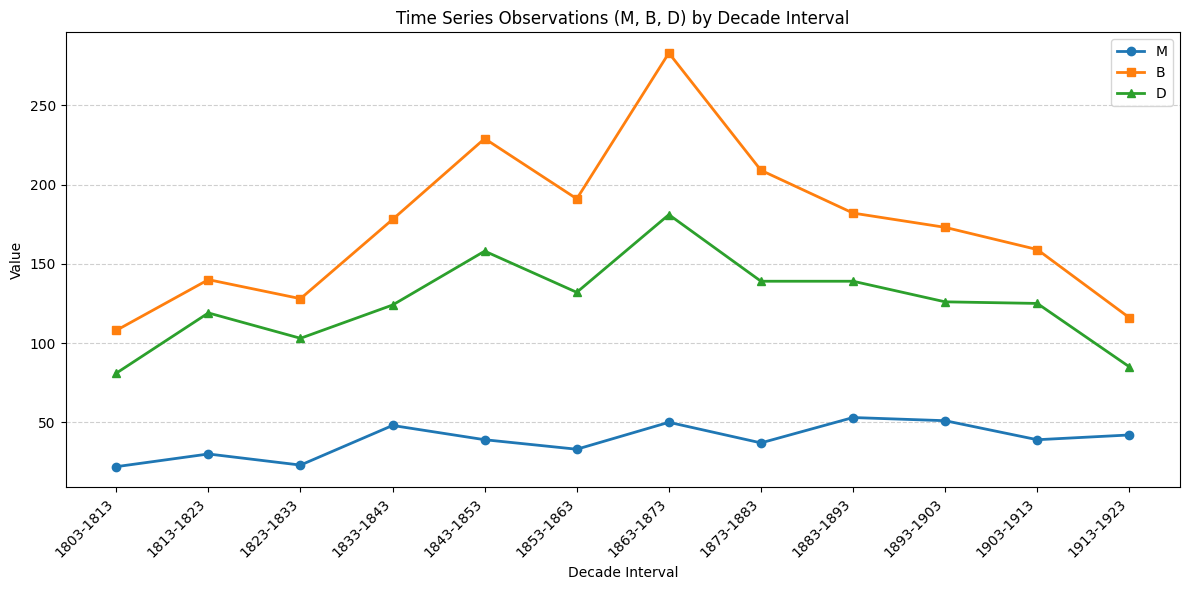


--- 2. Stationarity Test (ADF) ---
H0: The series is NON-STATIONARY. We reject H0 if p-value < 0.05.

Variable: M
  ADF Statistic: -1.161
  p-value: 0.690
  Conclusion: NON-STATIONARY (Accept H0)

Variable: B
  ADF Statistic: -1.646
  p-value: 0.459
  Conclusion: NON-STATIONARY (Accept H0)

Variable: D
  ADF Statistic: -2.004
  p-value: 0.285
  Conclusion: NON-STATIONARY (Accept H0)


--- 3. Stability in Variance Test (ARCH-LM) ---
H0: Residuals are HOMOSCEDASTIC (stable variance). Reject H0 if p-value < 0.05.

Variable: M
  ARCH-LM p-value (nlags=1): 0.415
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: B
  ARCH-LM p-value (nlags=1): 0.456
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: D
  ARCH-LM p-value (nlags=1): 0.254
  Conclusion: HOMOSCEDASTIC (Accept H0)


--- 4. VAR Model Estimation (Lag 1) ---
For demonstration, fixing the VAR lag to 1. Sample size N=12.

--- VAR Model Estimation Results (Lag 1) ---
  Summary of Regression Results   
Model:                         VAR

In [20]:

from statsmodels.stats.diagnostic import het_arch
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm # Corrected import for add_constant
import matplotlib.pyplot as plt

    

# --- 3. Stability in Variance Test (ARCH-LM) ---

print("\n--- 3. Stability in Variance Test (ARCH-LM) ---")
print("H0: Residuals are HOMOSCEDASTIC (stable variance). Reject H0 if p-value < 0.05.\n")

# Perform OLS on each variable against a time trend (data.index) to get residuals
for name in data.columns:
    # Use sm.add_constant for the intercept
    model_ols = OLS(data[name], sm.add_constant(data[name].index)).fit()
    
    # Use 'nlags=1' to check for ARCH effects
    arch_test = het_arch(model_ols.resid, nlags=1)
    
    p_value_lm = arch_test[1]
    
    decision = "HOMOSCEDASTIC (Accept H0)" if p_value_lm > 0.05 else "**HETEROSCEDASTIC (Reject H0)**"

    print(f"Variable: {name}")
    print(f"  ARCH-LM p-value (nlags=1): {p_value_lm:.3f}")
    print(f"  Conclusion: {decision}\n")




In [23]:
from statsmodels.tsa.api import VAR

# --- 4. VAR Model Estimation ---

print("\n--- 4. VAR Model Estimation (Lag 1) ---")

# Instantiate the VAR model
model = VAR(data)

# Fix the lag to 1.
optimal_lag = 1
print(f"For demonstration, fixing the VAR lag to {optimal_lag}. Sample size N={N}.\n")

# Fit the VAR model using the fixed lag
results = model.fit(optimal_lag)

# --- 5. Display VAR Results ---

print("--- VAR Model Estimation Results (Lag 1) ---")
print(results.summary())


--- 4. VAR Model Estimation (Lag 1) ---
For demonstration, fixing the VAR lag to 1. Sample size N=12.

--- VAR Model Estimation Results (Lag 1) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Nov, 2025
Time:                     10:14:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    16.9144
Nobs:                     11.0000    HQIC:                   16.2067
Log likelihood:          -125.467    FPE:                1.59492e+07
AIC:                      16.4803    Det(Omega_mle):     6.28988e+06
--------------------------------------------------------------------
Results for equation M
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        40.900703        23.530461            1.738           0.082
L1.M          0.1930

--- Loading User-Provided Time Series Data (N=12) ---
Original Data Head:
    M    B    D
0  22  108   81
1  30  140  119
2  23  128  103
3  48  178  124
4  39  229  158

--- Plotting Original Time Series Observations (Decade Intervals) ---


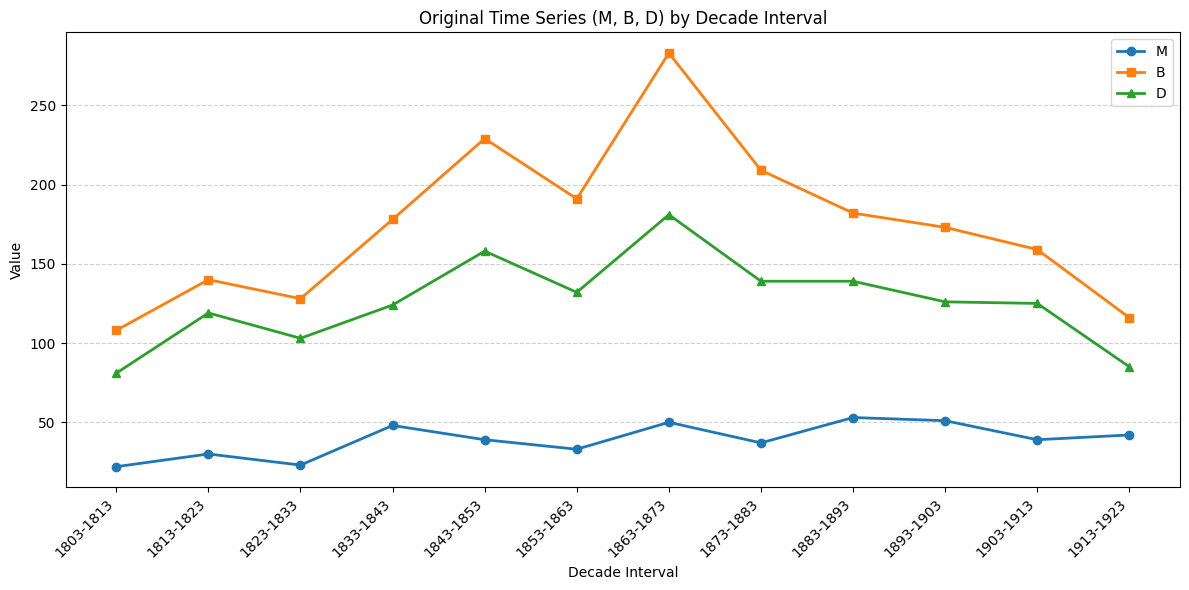


--- 2. Differencing the Data ---
Differenced Data Head (N=11):
      M     B     D
1   8.0  32.0  38.0
2  -7.0 -12.0 -16.0
3  25.0  50.0  21.0
4  -9.0  51.0  34.0
5  -6.0 -38.0 -26.0

--- Plotting Differenced Time Series Observations ---


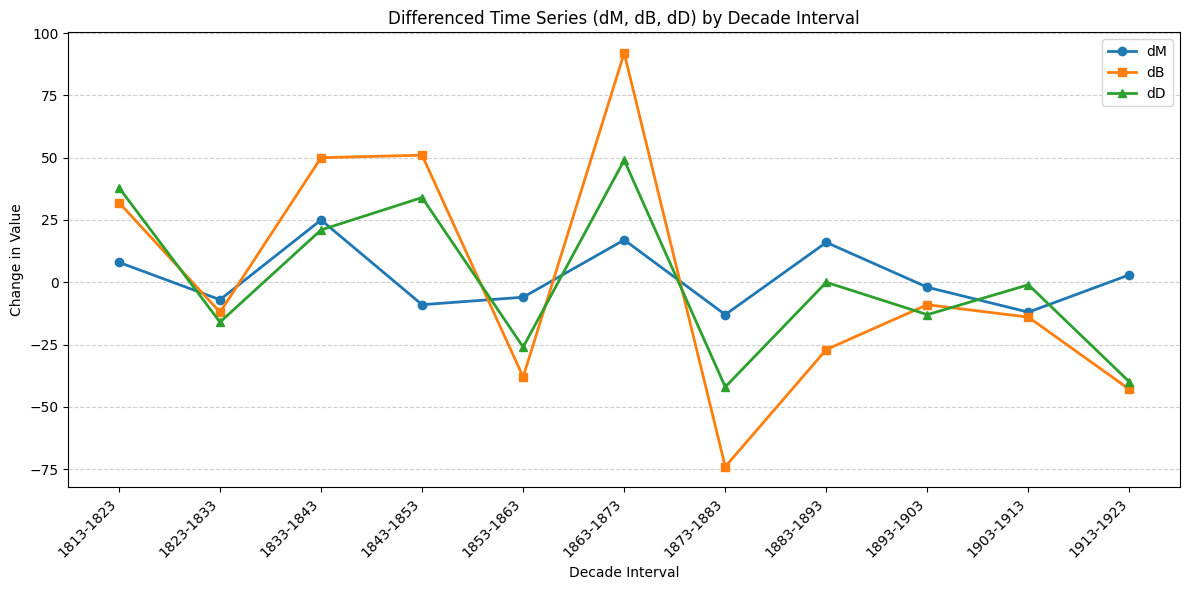


--- 3. Stationarity Test (ADF) on DIFFERENCED Data ---
H0: The series is NON-STATIONARY. We reject H0 if p-value < 0.05.

Variable: dM
  ADF Statistic: -3.618
  p-value: 0.005
  Conclusion: **STATIONARY (Reject H0)**

Variable: dB
  ADF Statistic: -3.924
  p-value: 0.002
  Conclusion: **STATIONARY (Reject H0)**

Variable: dD
  ADF Statistic: -4.956
  p-value: 0.000
  Conclusion: **STATIONARY (Reject H0)**


--- 4. Stability in Variance Test (ARCH-LM) on DIFFERENCED Data ---
H0: Residuals are HOMOSCEDASTIC (stable variance). Reject H0 if p-value < 0.05.

Variable: dM
  ARCH-LM p-value (nlags=1): 0.913
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: dB
  ARCH-LM p-value (nlags=1): 0.216
  Conclusion: HOMOSCEDASTIC (Accept H0)

Variable: dD
  ARCH-LM p-value (nlags=1): 0.376
  Conclusion: HOMOSCEDASTIC (Accept H0)


--- 5. VAR Model Estimation on DIFFERENCED Data (Lag 1) ---
For demonstration, fixing the VAR lag to 1. Sample size N=11.

--- VAR Model Estimation Results (Lag 1) on DIFF

In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm 
import matplotlib.pyplot as plt

# --- 1. Load User Data ---

print("--- Loading User-Provided Time Series Data (N=12) ---")

M_obs = [22, 30, 23, 48, 39, 33, 50, 37, 53, 51, 39, 42]
B_obs = [108, 140, 128, 178, 229, 191, 283, 209, 182, 173, 159, 116]
D_obs = [81, 119, 103, 124, 158, 132, 181, 139, 139, 126, 125, 85]
N = len(M_obs)

# Define date positions and custom interval labels (for original data plot)
date_positions = [1803, 1813, 1823, 1833, 1843, 1853, 1863, 1873, 1883, 1893, 1903, 1913]
date_labels = [f"{start_year}-{start_year + 10}" for start_year in date_positions]

# Combine into a Pandas DataFrame
data_level = pd.DataFrame({'M': M_obs, 'B': B_obs, 'D': D_obs})
print(f"Original Data Head:\n{data_level.head()}\n")

# --- 1.5. Plot the Original (Level) Data ---

print("--- Plotting Original Time Series Observations (Decade Intervals) ---")

plt.figure(figsize=(12, 6))
plt.plot(date_positions, data_level['M'], label='M', marker='o', linewidth=2)
plt.plot(date_positions, data_level['B'], label='B', marker='s', linewidth=2)
plt.plot(date_positions, data_level['D'], label='D', marker='^', linewidth=2)
plt.title('Original Time Series (M, B, D) by Decade Interval')
plt.xlabel('Decade Interval')
plt.ylabel('Value')
plt.xticks(date_positions, date_labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- 2. DIFFERENCE the Data to Achieve Stationarity ---

# Create the differenced data (delta_Y_t = Y_t - Y_{t-1})
data_diff = data_level.diff().dropna()
N_diff = len(data_diff)
print(f"\n--- 2. Differencing the Data ---")
print(f"Differenced Data Head (N={N_diff}):\n{data_diff.head()}\n")

# Create new date labels for the differenced data (starts one period later)
date_positions_diff = date_positions[1:]
date_labels_diff = date_labels[1:]

# --- 2.5. Plot the Differenced Data ---

print("--- Plotting Differenced Time Series Observations ---")

plt.figure(figsize=(12, 6))
plt.plot(date_positions_diff, data_diff['M'], label='dM', marker='o', linewidth=2)
plt.plot(date_positions_diff, data_diff['B'], label='dB', marker='s', linewidth=2)
plt.plot(date_positions_diff, data_diff['D'], label='dD', marker='^', linewidth=2)
plt.title('Differenced Time Series (dM, dB, dD) by Decade Interval')
plt.xlabel('Decade Interval')
plt.ylabel('Change in Value')
plt.xticks(date_positions_diff, date_labels_diff, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# --- 3. Stationarity Test (ADF) on DIFFERENCED Data ---

print("\n--- 3. Stationarity Test (ADF) on DIFFERENCED Data ---")
print("H0: The series is NON-STATIONARY. We reject H0 if p-value < 0.05.\n")

for name, series in data_diff.items():
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    test_statistic = result[0]
    
    decision = "NON-STATIONARY (Accept H0)" if p_value > 0.05 else "**STATIONARY (Reject H0)**"

    print(f"Variable: d{name}")
    print(f"  ADF Statistic: {test_statistic:.3f}")
    print(f"  p-value: {p_value:.3f}")
    print(f"  Conclusion: {decision}\n")
    
    
# --- 4. Stability in Variance Test (ARCH-LM) on DIFFERENCED Data ---

print("\n--- 4. Stability in Variance Test (ARCH-LM) on DIFFERENCED Data ---")
print("H0: Residuals are HOMOSCEDASTIC (stable variance). Reject H0 if p-value < 0.05.\n")

# Perform OLS on each differenced variable against a time trend
for name in data_diff.columns:
    # Estimate a simple model: dY_t = c + beta*t + epsilon_t
    model_ols = OLS(data_diff[name], sm.add_constant(data_diff[name].index)).fit()
    
    # Use 'nlags=1' to check for ARCH effects
    arch_test = het_arch(model_ols.resid, nlags=1)
    
    p_value_lm = arch_test[1]
    
    decision = "HOMOSCEDASTIC (Accept H0)" if p_value_lm > 0.05 else "**HETEROSCEDASTIC (Reject H0)**"

    print(f"Variable: d{name}")
    print(f"  ARCH-LM p-value (nlags=1): {p_value_lm:.3f}")
    print(f"  Conclusion: {decision}\n")


# --- 5. VAR Model Estimation on DIFFERENCED Data ---

print("\n--- 5. VAR Model Estimation on DIFFERENCED Data (Lag 1) ---")

# Instantiate the VAR model with the DIFFERENCED data
model = VAR(data_diff)

# Fix the lag to 1.
optimal_lag = 1
print(f"For demonstration, fixing the VAR lag to {optimal_lag}. Sample size N={N_diff}.\n")

# Fit the VAR model using the fixed lag
results = model.fit(optimal_lag)

# --- 6. Display VAR Results ---

print("--- VAR Model Estimation Results (Lag 1) on DIFFERENCED Data ---")
print(results.summary())

--- Data Setup: Loading and Differencing the Series ---
Using DIFFERENCED data with N=11 observations for VAR modeling.
--- VAR Model Estimated Successfully (Lag 1 on Differenced Data) ---

--- 3. Forecasting 3 Steps Ahead (dM, dB, dD) ---

Forecasts for Original Series (M, B, D) with 95% CI (Integrated):
              M_pred      B_pred      D_pred    M_lower     B_lower  \
1923-1933  55.120394  178.302940  129.793366  34.414472   79.259414   
1933-1943  42.506840  143.302170  102.697310  -4.412228  -67.504074   
1943-1953  55.953881  161.393462  114.876046 -19.938886 -169.784181   

             D_lower     M_upper     B_upper     D_upper  
1923-1933  79.364209   75.826316  277.346465  180.222523  
1933-1943 -10.654072   89.425907  354.108414  216.048692  
1943-1953 -69.313126  131.846649  492.571104  299.065218  

--- 5. Plotting Forecasts for Original Levels with 95% CI ---


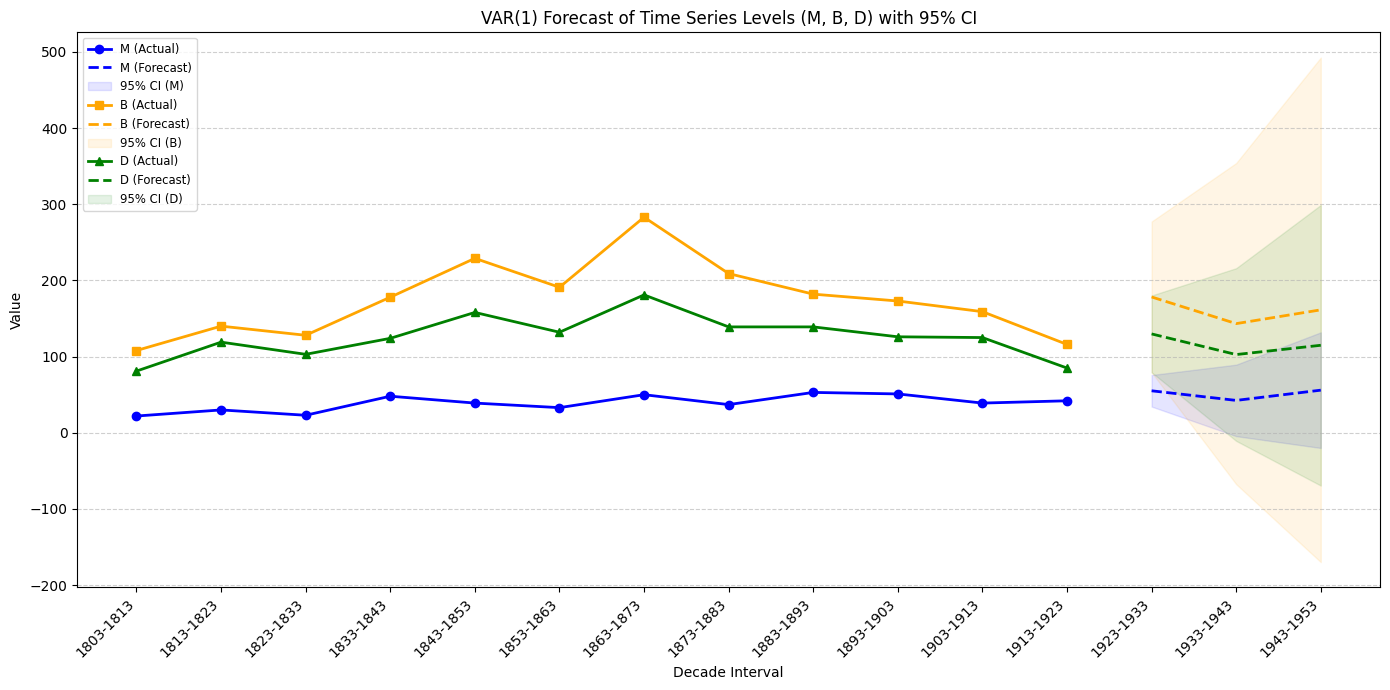

In [27]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm 
import matplotlib.pyplot as plt

# --- 1. Load and Difference Data (Setup for VAR) ---

print("--- Data Setup: Loading and Differencing the Series ---")

# Original Observations
M_obs = [22, 30, 23, 48, 39, 33, 50, 37, 53, 51, 39, 42]
B_obs = [108, 140, 128, 178, 229, 191, 283, 209, 182, 173, 159, 116]
D_obs = [81, 119, 103, 124, 158, 132, 181, 139, 139, 126, 125, 85]

data_level = pd.DataFrame({'M': M_obs, 'B': B_obs, 'D': D_obs})

# DIFFERENCE THE DATA to achieve stationarity
data_diff = data_level.diff().dropna()
N_diff = len(data_diff)

# Define date information
date_positions = [1803, 1813, 1823, 1833, 1843, 1853, 1863, 1873, 1883, 1893, 1903, 1913]
date_labels = [f"{start_year}-{start_year + 10}" for start_year in date_positions]
last_date_year = date_positions[-1]

print(f"Using DIFFERENCED data with N={N_diff} observations for VAR modeling.")

# --- 2. VAR Model Estimation ---

# Instantiate the VAR model with the DIFFERENCED data
model = VAR(data_diff)

# Fit the VAR model using lag 1
optimal_lag = 1
results = model.fit(optimal_lag)

print("--- VAR Model Estimated Successfully (Lag 1 on Differenced Data) ---")

# --- 3. Forecast and Confidence Intervals (on Differenced Data) ---

forecast_steps = 3 
print(f"\n--- 3. Forecasting {forecast_steps} Steps Ahead (dM, dB, dD) ---")

# Forecast the differenced series and get the 95% confidence intervals
forecast_result = results.forecast_interval(y=data_diff.values, steps=forecast_steps, alpha=0.05)

# Extract results
forecast_diff = pd.DataFrame(forecast_result[0], columns=['dM_pred', 'dB_pred', 'dD_pred'])
lower_diff = pd.DataFrame(forecast_result[1], columns=['dM_lower', 'dB_lower', 'dD_lower'])
upper_diff = pd.DataFrame(forecast_result[2], columns=['dM_upper', 'dB_upper', 'dD_upper'])


# --- 4. Revert Forecast to Original Level (Integration) ---

# Get the last observation of the original data (the anchor point)
last_obs = data_level.iloc[-1].values

# Initialize arrays for level forecasts and bounds
forecast_level = np.zeros_like(forecast_diff)
lower_level = np.zeros_like(lower_diff)
upper_level = np.zeros_like(upper_diff)

# Perform cumulative summation (integration) to get the level forecast
for i in range(forecast_steps):
    if i == 0:
        # Step 1: Last Actual Level + Forecasted Change
        forecast_level[i] = last_obs + forecast_diff.iloc[i].values
        lower_level[i] = last_obs + lower_diff.iloc[i].values
        upper_level[i] = last_obs + upper_diff.iloc[i].values
    else:
        # Subsequent steps: Previous Forecasted Level + Current Forecasted Change
        forecast_level[i] = forecast_level[i-1] + forecast_diff.iloc[i].values
        lower_level[i] = lower_level[i-1] + lower_diff.iloc[i].values
        upper_level[i] = upper_level[i-1] + upper_diff.iloc[i].values

# Convert integrated forecasts to DataFrame
forecast_M = pd.DataFrame(forecast_level, columns=['M_pred', 'B_pred', 'D_pred'])
lower_M = pd.DataFrame(lower_level, columns=['M_lower', 'B_lower', 'D_lower'])
upper_M = pd.DataFrame(upper_level, columns=['M_upper', 'B_upper', 'D_upper'])

# Generate new date labels for the forecast steps
forecast_start_year = last_date_year + 10
forecast_dates = [forecast_start_year + i * 10 for i in range(forecast_steps)]
forecast_labels = [f"{start_year}-{start_year + 10}" for start_year in forecast_dates]

forecast_df_level = pd.concat([forecast_M, lower_M, upper_M], axis=1)
forecast_df_level.index = forecast_labels

print("\nForecasts for Original Series (M, B, D) with 95% CI (Integrated):")
print(forecast_df_level)

# --- 5. Plotting Forecasts for Original Level Data ---

print("\n--- 5. Plotting Forecasts for Original Levels with 95% CI ---")

# Prepare data for plotting the full series (Actual + Forecast)
full_dates = date_positions + forecast_dates
full_labels = date_labels + forecast_labels
N = len(data_level)

# Actual data extended with NaNs
M_actual = data_level['M'].tolist() + [np.nan] * forecast_steps
B_actual = data_level['B'].tolist() + [np.nan] * forecast_steps
D_actual = data_level['D'].tolist() + [np.nan] * forecast_steps

# Forecast data (NaNs for actual period)
M_pred = [np.nan] * N + forecast_df_level['M_pred'].tolist()
B_pred = [np.nan] * N + forecast_df_level['B_pred'].tolist()
D_pred = [np.nan] * N + forecast_df_level['D_pred'].tolist()

# Confidence Bounds (NaNs for actual period)
M_lower = [np.nan] * N + forecast_df_level['M_lower'].tolist()
M_upper = [np.nan] * N + forecast_df_level['M_upper'].tolist()


plt.figure(figsize=(14, 7))

# Plot M Series
plt.plot(full_dates, M_actual, label='M (Actual)', marker='o', linewidth=2, color='blue')
plt.plot(full_dates, M_pred, label='M (Forecast)', linestyle='--', linewidth=2, color='blue')
# Plot M Confidence Interval
plt.fill_between(full_dates, M_lower, M_upper, alpha=0.1, color='blue', label='95% CI (M)')

# Plot B Series
plt.plot(full_dates, B_actual, label='B (Actual)', marker='s', linewidth=2, color='orange')
plt.plot(full_dates, B_pred, label='B (Forecast)', linestyle='--', linewidth=2, color='orange')
# Plot B Confidence Interval
plt.fill_between(full_dates, [np.nan] * N + forecast_df_level['B_lower'].tolist(), [np.nan] * N + forecast_df_level['B_upper'].tolist(), alpha=0.1, color='orange', label='95% CI (B)')


# Plot D Series
plt.plot(full_dates, D_actual, label='D (Actual)', marker='^', linewidth=2, color='green')
plt.plot(full_dates, D_pred, label='D (Forecast)', linestyle='--', linewidth=2, color='green')
# Plot D Confidence Interval
plt.fill_between(full_dates, [np.nan] * N + forecast_df_level['D_lower'].tolist(), [np.nan] * N + forecast_df_level['D_upper'].tolist(), alpha=0.1, color='green', label='95% CI (D)')


plt.title(f'VAR(1) Forecast of Time Series Levels (M, B, D) with 95% CI')
plt.xlabel('Decade Interval')
plt.ylabel('Value')
plt.xticks(full_dates, full_labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()